# 豆瓣高分纪录片爬取与分析

In [260]:
#载入所需数据库
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## 爬取纪录片排行榜

网页来源于豆瓣[纪录片类别按评分排序](https://movie.douban.com/tag/%E7%BA%AA%E5%BD%95%E7%89%87?start=0&type=S)
可以看到：  
1.每页出现的结果不一样：第一页19条，之后每页20条记录。  
2.纪录片列表在名为div，属性class_为空的标签中
3.每条记录储存在一个class为空，名为table的标签之中  


In [261]:
def download_webpage(url):
    return requests.get(url).content

In [262]:
movie_name_list = []
def parse_page(html):
    soup = BeautifulSoup(html, 'html.parser')
    movie_list = soup.find_all('div', class_ = "")[1]
    for movie in movie_list.find_all('table', class_ = ""):
        if movie.find(class_ = 'rating_nums') == None:  #调BUG的时候发现存在无人评分的纪录片
            continue
        movie_name_list.append({"RANK":len(movie_name_list)+1,"NAME":movie.find('a', class_ = "nbg").attrs['title'],
                               "RATING":movie.find(class_ = 'rating_nums').text,
                              "URL":movie.find('a', class_ = "nbg").attrs['href']})
        
    if soup.find('span', class_ = "next").find('link') !=  None: #爬到最后一页
        next_url = soup.find('span', class_ = "next").find('link').attrs['href']
        return next_url
    return None
    

In [263]:
#主程序
URL = "https://movie.douban.com/tag/%E7%BA%AA%E5%BD%95%E7%89%87?start=0&type=S"
movie_name_list = []
while URL:
    URL = parse_page(download_webpage(URL))


In [265]:
movie_name_list

[{'NAME': '蓝色星球2',
  'RANK': 1,
  'RATING': '9.9',
  'URL': 'https://movie.douban.com/subject/26979545/'},
 {'NAME': '地球脉动 第二季',
  'RANK': 2,
  'RATING': '9.9',
  'URL': 'https://movie.douban.com/subject/26733371/'},
 {'NAME': '猎捕',
  'RANK': 3,
  'RATING': '9.8',
  'URL': 'https://movie.douban.com/subject/26576692/'},
 {'NAME': '地球脉动2：奇迹世界',
  'RANK': 4,
  'RATING': '9.8',
  'URL': 'https://movie.douban.com/subject/27087625/'},
 {'NAME': '人类星球',
  'RANK': 5,
  'RATING': '9.8',
  'URL': 'https://movie.douban.com/subject/5950117/'},
 {'NAME': '冰冻星球',
  'RANK': 6,
  'RATING': '9.8',
  'URL': 'https://movie.douban.com/subject/6886533/'},
 {'NAME': 'BBC：非洲',
  'RANK': 7,
  'RATING': '9.8',
  'URL': 'https://movie.douban.com/subject/20488575/'},
 {'NAME': '十冠之心',
  'RANK': 8,
  'RATING': '9.7',
  'URL': 'https://movie.douban.com/subject/26411395/'},
 {'NAME': '最后的棒棒',
  'RANK': 9,
  'RATING': '9.7',
  'URL': 'https://movie.douban.com/subject/26636841/'},
 {'NAME': '地球脉动 第一季',
  'RANK': 10,


## 爬取在榜纪录片的详尽信息

In [266]:
def movie_parser(movie):
    URL = movie['URL']
    page = download_webpage(URL)
    soup = BeautifulSoup(page, 'html.parser')
    movie['NAME'] = soup.find('span',property="v:itemreviewed" ).text
    if soup.find('span', class_ = 'year') != None: #还真有页面不标年份的
        movie['YEAR'] = int(soup.find('span', class_ = 'year').text[1:-1]) #形如（2XXX）
    else:
        movie['YEAR'] = 0   
    AREA = []  #制片国家/地区的名字居然没有标签？！， 只能硬来了
    for i in soup.find('div', id = 'info').text.split('\n'):
        if '制片国家/地区' in i:
            for k in i.split(':')[1].split('/'):
                AREA.append(k.strip())
    movie['AREA'] = AREA
    movie['TAGS'] = soup.find('div', class_ = 'tags-body').text.split('\n')[1:-1]
    movie['AUDIENCE'] = int(soup.find('span', property = 'v:votes').text)
    return movie

In [267]:
movie_list = movie_name_list
for movie in movie_list:
    movie = movie_parser(movie)

In [269]:
#
import pandas as pd
df = pd.DataFrame(movie_list)

In [271]:
df.to_csv('data/豆瓣高分纪录片数据.csv')

## TAG探寻

每一部纪录片页面都有个标签板块，代表着该纪录片所对应的特点：如自然、历史等。这让我好奇在这些高分的记录片里，标签的分布是怎样的，人们究竟喜欢怎样的纪录片？

In [1224]:
# GET TAGS 
#为了更好的统计标签频率，我将标签次数设为SUM(评论人数权重)
#权重为: >1000:2, >5000:5, >10000:10
TAGS = {}
for i in range(df.shape[0]):
    for tag in df['TAGS'][i]:
        if tag in TAGS.keys():
            TAGS[tag] += df['AUDIENCE'][i]
        else:
            TAGS[tag] = df['AUDIENCE'][i]
#因为我们的数据都是记录片，所以删除TAG “纪录片”与“紀錄片”
del TAGS['纪录片']
del TAGS[ '紀錄片']
del TAGS['记录片']
del TAGS[ 'Documentary']
del TAGS[ 'documentary']
#删除年份数据：
delyear = []
for key in TAGS.keys():
    if '20' in key:
        delyear.append(key)
for year in delyear:
    del TAGS[year]
#删除国家相关的标签数据
del TAGS['中国']
del TAGS['中国大陆']
del TAGS['大陆']
del TAGS['英国']
del TAGS['美国']
del TAGS['日本']
del TAGS['法国']
del TAGS['美国电影']
del TAGS['法国电影']
del TAGS['BBC']
del TAGS['国产']
del TAGS['CCTV']

In [1252]:
se = pd.Series(TAGS)
se.to_csv('data/标签频率统计.csv')

In [1253]:
se.describe()

count      1862.000000
mean       6098.974758
std       26468.961240
min         124.000000
25%         331.000000
50%         761.000000
75%        2626.000000
max      552797.000000
dtype: float64

可以看出标签分布不均匀的情况实在是太严重了，上分位数75%也才为2665，与最大值差了2个数量集。

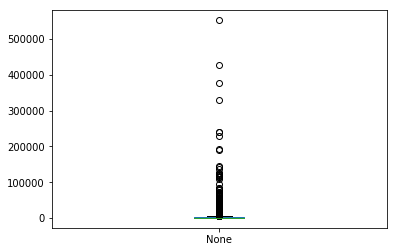

In [1254]:
se.plot(kind = 'box')

In [1229]:
#从上面的分析可以看出，标签的样本空间为1800+，是样本的近2倍，且标签出现的次数分布相差巨大。为了防止维度过大的影响与专注于常用的标签，
#我本次只取标签出现次数大于50,000的标签,将出现次数与最高次数控制在一个数量级内，我将这些标签称为“热门标签”
se = se[se.values>50000]

In [1230]:
#将TAG数据写入DataFrame
for movie in movie_list:
    for tag in movie['TAGS']:
        if tag in se.index:
            movie[tag+'_judge'] = 1
    del movie['TAGS']

In [1231]:
tagdf = pd.DataFrame(movie_list).fillna(0)

In [1232]:
tagdf = tagdf.drop(['AREA','YEAR', 'URL','RATING','RANK','AUDIENCE'], axis = 1) #此次分析只关注与代表影片特征的标签，因此将YEAR、AREA与无关特征一并删除

In [1233]:
tagdf = tagdf.set_index('NAME')

In [1255]:
tagdf.columns

Index(['二战_judge', '人性_judge', '人文_judge', '人生_judge', '传承_judge', '传记_judge',
       '动物_judge', '励志_judge', '博物馆_judge', '历史_judge', '吃货_judge',
       '国家地理_judge', '地球村_judge', '央视_judge', '寿司_judge', '平常生活_judge',
       '慰安妇_judge', '成长_judge', '我在故宫修文物_judge', '战争_judge', '探索_judge',
       '政治_judge', '故宫_judge', '文化_judge', '文物_judge', '旅行_judge', '残酷_judge',
       '每个人_judge', '海洋_judge', '温情_judge', '环保_judge', '生活_judge', '社会_judge',
       '科普_judge', '纪实_judge', '纪录_judge', '纪录片cctv9_judge', '经典_judge',
       '综艺_judge', '美食_judge', '自然_judge', '艺术_judge', '英国电影_judge',
       '雅克·贝汉_judge', '震撼_judge'],
      dtype='object')

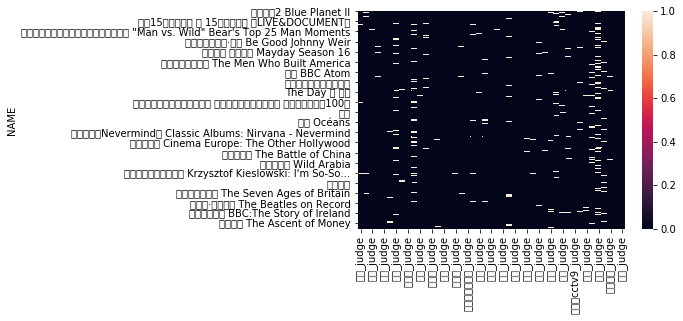

In [1261]:
sns.heatmap(tagdf)

通过上图可以看到，即便我选取的已经是“热门标签”了，但上图仍十分的“稀疏”（0代表着该影片不含此标签），除了一些及其热门的标签（某一列许多白色，代表着影片有该标签）。下面对标签数据进行聚类分析，探究豆瓣用户喜欢的高分纪录片都是哪些种类的。

## 降维

In [1276]:
# 降维，从上图中可以看出标签数据在全部900多个影片中分布十分稀疏，因此对这些数据进行降维操作以便后续进行分析
from sklearn.decomposition import PCA
pca = PCA(n_components=26)
pcadf = pca.fit_transform(tagdf)
np.sum(pca.explained_variance_ratio_) 

0.94837611884888195

这些主成分的累计贡献率约为0.95，可以进行使用

## 对数据进行聚类操作

下面采用聚类方法将高分纪录片分类，采用K均值算法进行分类。

In [1277]:
#确定最优的分类类别数，采用轮廓系数进行判别，轮廓系数取值为[-1, 1]，越接近1说明类别中的样本越近似
from sklearn.cluster import KMeans
for i in np.arange(2,10):
    kmeans = KMeans(n_clusters=i, random_state=66).fit(pcadf)
    preds = kmeans.predict(pcadf)
    from sklearn.metrics import silhouette_score
    score = silhouette_score(test, preds)
    print(score)

0.305551476701
0.335171381411
0.356277271362
0.363600336851
0.40536177537
0.403083443333
0.434853941564
0.442456830275


可以看出当分类数n_clusters = 6后，总的轮廓系数达到了0.4，并在之后随分类数的提升总的轮廓系数的得分提高不大，因此决定分出6个类别。

In [1280]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=66).fit(pcadf)
#对各个样本进行预测
preds = kmeans.predict(pcadf)
# T找到各个聚类的中心
centers = kmeans.cluster_centers_

In [1281]:
#首先查看各个聚类的样本占总样本的比重。
for i in range(6):
    counter = 0
    for k in preds:
        if k==i:
            counter += 1
    print('The rate of centers%d is %f:'  %(i,counter/len(preds)))

The rate of centers0 is 0.562436:
The rate of centers1 is 0.123839:
The rate of centers2 is 0.092879:
The rate of centers3 is 0.098039:
The rate of centers4 is 0.043344:
The rate of centers5 is 0.079463:


可以看出centers0类的纪录片占据了半壁江山，而其他类别的纪录片分布较为均匀，都在10%左右。

In [1282]:
#我将样本中出现“热门标签”对应1，没有则对应于0。所以若一个样本中某个标签对应的数据越接近于1，则倾向于该样本具有该标签。
#通过观察这6个聚类的中心样本数据，我可以观察到这6个聚类分别对应着哪6种类型的纪录片。
for i in range(6):
    print('centers %d:'%i)
    tem = pca.inverse_transform(centers[i]).tolist()
    for j in sorted(pca.inverse_transform(centers[i]), reverse = True)[:3]: #查看前三个最大值（越大越接近于1）
        index_num = tem.index(j)
        tem[index_num] = 0
        print(tagdf.columns[index_num], j)

centers 0:
艺术_judge 0.062371313707
旅行_judge 0.0605520180789
纪实_judge 0.0459461233317
centers 1:
历史_judge 0.999960736637
战争_judge 0.158673206156
二战_judge 0.116332577013
centers 2:
自然_judge 1.00019328141
海洋_judge 0.121859882458
环保_judge 0.111160689416
centers 3:
动物_judge 0.999949128934
自然_judge 0.65264323409
国家地理_judge 0.0947494925291
centers 4:
美食_judge 0.999734062668
吃货_judge 0.0497597440505
英国电影_judge 0.0479937540834
centers 5:
科普_judge 0.999907971648
自然_judge 0.129847944824
国家地理_judge 0.129833460067


**centers0：** 杂食系。最大值也不到0.1，远低于1。这说明该类样本中倾向与不具有任何“热门标签”，即该类纪录片没有一个热门的特征（标签）能够概括，这个类别里包含了各种各样的纪录片类型，且占所有样本的比重超过一半，也可以侧面说明豆瓣用户对纪录片的品味还是十分“杂食”的。the rate of centers[0] is 0.562436:  
**centers1：** 历史类纪录片。the rate of centers[1] is 0.123839   
**centers2：** 自然类纪录片。the rate of centers[2] is 0.092879  
**centers3：** 动物类纪录片。the rate of centers[3] is 0.098039  
**centers4：** 美食类摄的纪录片。the rate of centers[4] is 0.043344  
**centers5：** 科普类纪录片。the rate of centers[5] is 0.079463  
从纪录片的类型来看，豆瓣高分纪录片的类型可以说是包罗万象，超过一半的高分榜纪录片不能归结于某一特定的类型，这也从另一角度说明了豆瓣用户喜好的多样性，而近一半的高分纪录片可以分类为：历史、自然、动物、美食、科普这几大类，可以看出豆瓣用户对这几大类型的纪录片十分的热爱。